In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm

from models import *
from utils.loss import *

In [2]:
device = torch.device('cuda')

# Fine-Grained Model

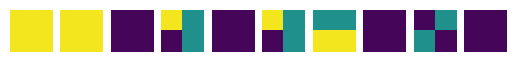

In [3]:
fine = FineRBM(1, device)
fine.plot_samples(n=10, k=32)

# $A_1$ Representation

In [4]:
coarse_a1 = A1_RBM(device)

optimizer = torch.optim.Adam(coarse_a1.parameters(), lr=0.001)

losses = []
Js = []

In [5]:
iters = 10000
batch_n = 8
k = 32

for i in tqdm(range(iters)):
    optimizer.zero_grad()

    loss = free_energy_difference(
        fine, coarse_a1, 
        batch_n=batch_n, k=k
    )
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        losses.append(float(loss))
        Js.append(float(coarse_a1.J))

100%|████████████████████████████████████| 10000/10000 [01:05<00:00, 152.12it/s]


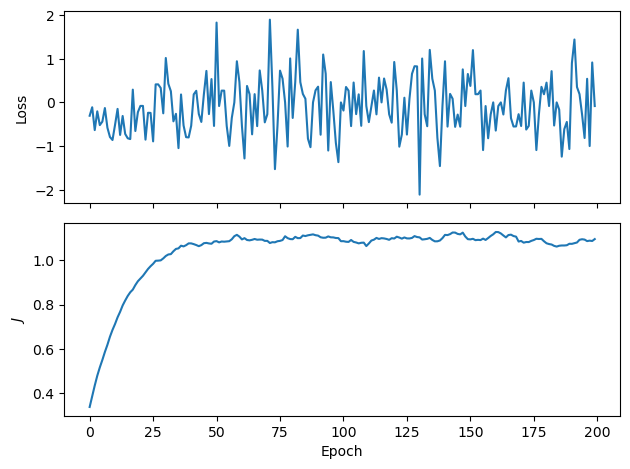

In [6]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
ax0.plot(losses)
ax0.set_ylabel('Loss')
ax1.plot(Js)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('$J$');

fig.tight_layout()

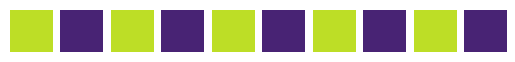

In [7]:
coarse_a1.plot_samples(n=10, k=32)

# $A_1 \oplus E$ Representation

In [8]:
coarse_a1e = A1_E_RBM(device)

optimizer = torch.optim.Adam(coarse_a1e.parameters(), lr=0.001)

losses = []
J_As = []
J_Es = []

In [9]:
iters = 10000
batch_n = 8
k=32

for i in tqdm(range(iters)):
    optimizer.zero_grad()

    loss = free_energy_difference(
        fine, coarse_a1e, 
        batch_n=batch_n, k=k
    )
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        losses.append(float(loss))
        J_As.append(float(coarse_a1e.J_A))
        J_Es.append(float(coarse_a1e.J_E))

100%|████████████████████████████████████| 10000/10000 [01:16<00:00, 130.00it/s]


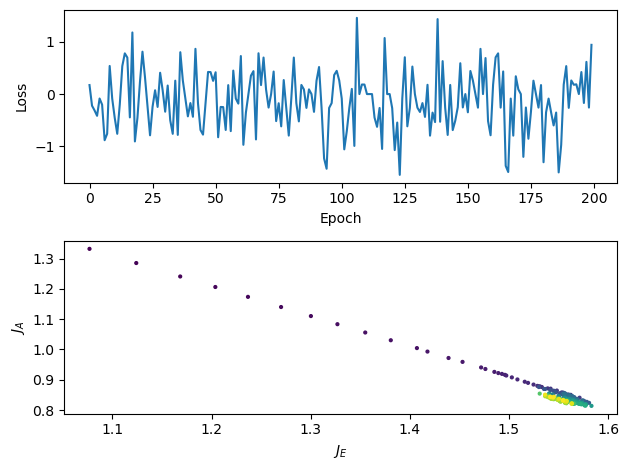

In [10]:
fig, (ax0, ax1) = plt.subplots(2, 1)
ax0.plot(losses)
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax1.scatter(J_As, J_Es, c=range(len(J_As)), cmap='viridis', s=4)
ax1.set_xlabel('$J_E$')
ax1.set_ylabel('$J_A$');

fig.tight_layout()

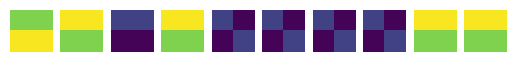

In [11]:
coarse_a1e.plot_samples(n=10, k=32)